In [16]:
# Data Loading
import json 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Text PreProcessing
import re,nltk,spacy,string
nlp=spacy.load("en_core_web_sm")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

# Model Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# row/column display limit
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [17]:
# Opening JSON file 
j = open('/Users/nishitgoyal/Documents/Personal Docs/Data Sceince/complaints-2021-05-14_08_16.json',)
  
# Returns JSON object as a dictionary 
data = json.load(j)

# Create a dataframe out of dictionary 
df = pd.json_normalize(data)

In [18]:

df.shape


(78313, 22)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [15]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [23]:
#source.complaint_what_happened is most important columns.It has  many blank row.Lets handle them
df['_source.complaint_what_happened'].replace("", np.nan, inplace=True)
# Inspecting the number of missing values percentage again
round(df.isna().sum()*100/78313,2)

_index                                0.00
_type                                 0.00
_id                                   0.00
_score                                0.00
_source.tags                         86.08
_source.zip_code                      8.63
_source.complaint_id                  0.00
_source.issue                         0.00
_source.date_received                 0.00
_source.state                         2.54
_source.consumer_disputed             0.00
_source.product                       0.00
_source.company_response              0.00
_source.company                       0.00
_source.submitted_via                 0.00
_source.date_sent_to_company          0.00
_source.company_public_response      99.99
_source.sub_product                  13.50
_source.timely                        0.00
_source.complaint_what_happened      73.09
_source.sub_issue                    59.12
_source.consumer_consent_provided     1.29
dtype: float64

In [25]:
#There are 73 % blank datain complaint_what_happened.Lets Drop them
df.dropna(subset=['_source.complaint_what_happened'], inplace=True)

#New shape of df
df.shape

(21072, 22)

In [26]:
#Assign new column names
#Removing "_" from column names
df.columns=[re.sub('^_','',col) for col in df.columns]

#Removing "source." from column names
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]

list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [27]:
df.head()


,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported i

# Prepare the Text for topic modelling

In [29]:
#Remove some unnecessary elements
def clean_texts(text):
    #Make the text lowercase
    text=text.lower()
    
    #Remove text in square brackets
    text=re.sub(r'\[.*?\]','',text)
    
    #Remove punctuation
    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)
    
    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [30]:
df['complaint_what_happened']= df['complaint_what_happened'].apply(lambda x: clean_texts(x))


In [31]:
def lemma_texts(text):     
        
    # Initialize empty list to store lemmas
    lemma_list = []
    
    # Extract lemmas of given text and add to the list 'sent'
    document = nlp(text)
    for word in document:
        lemma_list.append(word.lemma_)
        
    # return string converted form of the list of lemmas
    return " ".join(lemma_list)

In [32]:
# Add a column for lemmatized complaints to the dataframe
df["lemmatized_complaint"] =  df.apply(lambda x: lemma_texts(x['complaint_what_happened']), axis=1)

# View the dataframe
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.",Information belongs to someone else,Consent provided,"chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant ."
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen t

In [33]:
#complaint vs Lemmatized complaint
df_clean=df[['complaint_what_happened','lemmatized_complaint']]

In [34]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant ."
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.","on xx / xx/ , while try to book a xxxx xxxx ticket , I come across an offer for { $ . } to be apply towards the ticket if I apply for a reward card . I put in my information for the offer and within less than a minute , be notify via the screen that a decision could not be make . I immediately contact xxxx and be refer to chase bank . I then immediately contact ch

### Extract POS Tags

In [39]:
# Extracting singular nouns
def singular_nouns(text):
   
    
    # Creating a textblob object
    text_blob = TextBlob(text)
    
    # extracting words with tags 'NN', joining them and return
    return ' '.join([ word for (word,tag) in text_blob.tags if tag == "NN"])

In [41]:
df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: singular_nouns(x['lemmatized_complaint']), axis=1)

# View the dataframe
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.","on xx / xx/ , 

### EDA ON DATA

Text(0, 0.5, 'No. of Complaints')

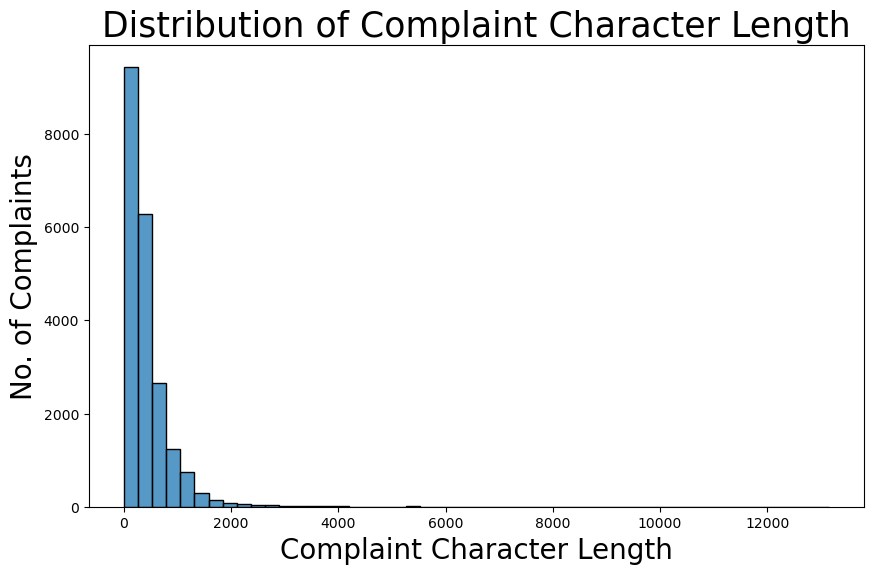

In [44]:
#Length of complaint
char_len=[len(x) for x in df_clean['complaint_POS_removed']]
char_len[:10]
plt.figure(figsize=[10,6])
sns.histplot(data = char_len,bins=50)
plt.title('Distribution of Complaint Character Length', fontsize=25)
plt.xlabel('Complaint Character Length',size=20)
plt.ylabel('No. of Complaints',size=20)

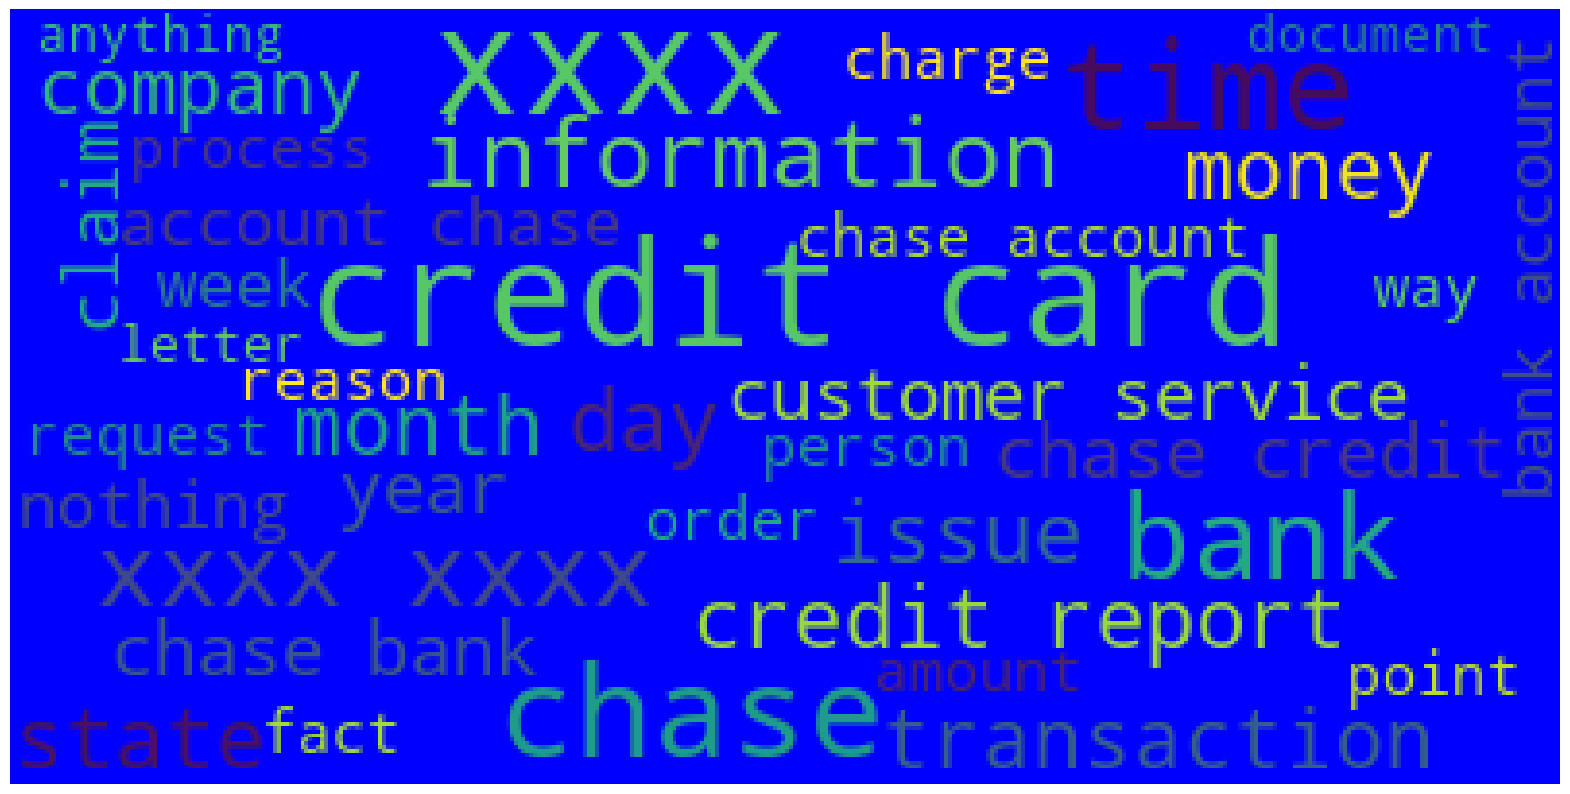

In [45]:
#Top 50 Words

stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='blue',
                          stopwords=stop_words,
                          max_font_size=38,
                          max_words=38, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,16))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()


In [46]:
#Lets find bigram,unigram and trigram

In [48]:

def get_top_ngrams(text, ngram_range=(1, 1), n=30):

    vector = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    return word_freq[:n]

In [57]:

df_unigram = get_top_ngrams(df_clean['complaint_POS_removed'].values.astype('U'), ngram_range=(1, 1), n=30)
top_unigrams_df = pd.DataFrame(df_unigram, columns=['Unigram', 'Frequency'])
# For bigrams:
df_bigrams = get_top_ngrams(df_clean['complaint_POS_removed'].values.astype('U'), ngram_range=(2, 2), n=30)
top_bigrams_df = pd.DataFrame(df_bigrams, columns=['bigram', 'Frequency'])
# For trigrams:
df_trigrams = get_top_ngrams(df_clean['complaint_POS_removed'].values.astype('U'), ngram_range=(3, 3), n=30)
top_triigrams_df = pd.DataFrame(df_trigrams, columns=['trigram', 'Frequency'])

In [60]:
df_unigram

[('chase', 49212),
 ('account', 47913),
 ('xxxx', 43304),
 ('credit', 34300),
 ('card', 29633),
 ('bank', 28503),
 ('payment', 21338),
 ('time', 16281),
 ('charge', 15153),
 ('day', 13073),
 ('check', 12168),
 ('money', 11999),
 ('loan', 11063),
 ('state', 9713),
 ('letter', 9709),
 ('information', 9680),
 ('report', 9021),
 ('fee', 8793),
 ('transaction', 8659),
 ('number', 8637),
 ('month', 8557),
 ('year', 8352),
 ('mortgage', 8231),
 ('customer', 8194),
 ('claim', 7897),
 ('balance', 7779),
 ('service', 7772),
 ('phone', 7744),
 ('company', 7651),
 ('fraud', 7196)]

In [62]:
df_bigrams

[('credit card', 12878),
 ('xxxx xxxx', 6249),
 ('credit report', 3964),
 ('customer service', 3082),
 ('chase credit', 3064),
 ('chase bank', 2935),
 ('account chase', 2761),
 ('bank account', 2751),
 ('chase account', 2718),
 ('account account', 2307),
 ('check account', 2173),
 ('account bank', 1756),
 ('xxxx chase', 1686),
 ('debit card', 1652),
 ('card account', 1624),
 ('credit score', 1597),
 ('account xxxx', 1526),
 ('account credit', 1502),
 ('payment payment', 1392),
 ('card chase', 1356),
 ('money account', 1349),
 ('checking account', 1326),
 ('xxxx account', 1303),
 ('phone number', 1270),
 ('business day', 1267),
 ('charge account', 1233),
 ('credit account', 1227),
 ('account number', 1138),
 ('card company', 1131),
 ('card card', 1067)]

In [63]:
df_trigrams

[('chase credit card', 2140),
 ('xxxx xxxx xxxx', 1063),
 ('credit card account', 1056),
 ('credit card company', 995),
 ('credit card chase', 673),
 ('credit card credit', 506),
 ('inquiry credit report', 483),
 ('charge credit card', 430),
 ('account credit card', 414),
 ('card credit card', 382),
 ('credit reporting agency', 377),
 ('xxxx credit card', 366),
 ('credit card bank', 362),
 ('bank credit card', 355),
 ('credit reporting act', 336),
 ('credit report credit', 335),
 ('credit card xxxx', 315),
 ('credit card charge', 309),
 ('credit card payment', 301),
 ('account credit report', 289),
 ('account chase account', 281),
 ('chase customer service', 270),
 ('credit card balance', 265),
 ('consumer protection bureau', 256),
 ('credit card card', 256),
 ('victim identity theft', 250),
 ('chase fraud department', 243),
 ('credit card service', 241),
 ('freedom credit card', 236),
 ('payment credit card', 235)]

In [64]:
#remove XXXX
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')
df_clean.head()


,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account change date consent recording agent
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.","on xx / xx/ , while try 

### Feature Extraction

In [68]:
#Remove terms that appear more than in 95& of complaints or in less than 2 complaints
df_cleaner=df_clean.copy()
df_clean=df_cleaner.copy()
tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')


In [69]:
dtm=tfidf.fit_transform(df_clean['complaint_POS_removed'])

### NMF

In [ ]:
from sklearn.decomposition import NMF


In [65]:
#Coherence model to find best number of topics
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['complaint_POS_removed']
data_set = [x.split() for x in texts]

# Creating a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(data_set)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Creating the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in data_set]

# Create a list of the topic numbers we want to try
topic_num = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_num:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=40
    )
    
    # Run the coherence model to get the score
    coherence_model = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(coherence_model.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_num, coherence_scores))
best_topics_num = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_topics_num)

5


In [71]:
df_cleanx =df_clean.copy()
nmf_model = NMF(n_components=5,random_state=40)
nmf_model.fit(dtm)


NMF(n_components=5, random_state=40)

In [74]:
# Print the top word of a sample component
topic_single = nmf_model.components_[0]
topic_single.argsort()
top_word_index = topic_single.argsort()[-10:]
for index in top_word_index:
    print(tfidf.get_feature_names_out()[index])

number
day
branch
deposit
chase
fund
money
bank
check
account


In [76]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP 15 WORDS FOR TOPIC #0
['customer', 'transfer', 'claim', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


TOP 15 WORDS FOR TOPIC #1
['year', 'balance', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


TOP 15 WORDS FOR TOPIC #2
['mortgage', 'year', 'chase', 'account', 'credit', 'date', 'pay', 'time', 'day', 'auto', 'statement', 'fee', 'month', 'balance', 'payment']


TOP 15 WORDS FOR TOPIC #3
['company', 'refund', 'statement', 'time', 'service', 'claim', 'purchase', 'fraud', 'merchant', 'dispute', 'transaction', 'fee', 'chase', 'card', 'charge']


TOP 15 WORDS FOR TOPIC #4
['sale', 'house', 'foreclosure', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'modification', 'chase', 'home', 'mortgage', 'loan']




In [77]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_result = nmf_model.transform(dtm)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)

array([4, 1, 1, ..., 3, 2, 2])

In [78]:
# Create a new 'Topic' column and assign the best topic to each of the complaints

df_clean['Topic'] = topic_result.argmax(axis=1)

In [79]:
df_clean.shape


(21072, 4)

In [80]:
df_clean.head()


,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account change date consent recording agent,1
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant,1
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.","on xx / xx/ 

In [ ]:
#Map It with Relvant Topics

In [88]:
df_clean.replace({'Topic':{0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}},inplace=True)

df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,Mortgage/Loan
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account change date consent recording agent,Credit card or prepaid card
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant,Credit card or prepaid card
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application w

In [ ]:
#Supervised model to predict any new complaints to the relevant Topics.


In [89]:
# Create the dictionary again of Topic names and Topic numbers and replace

df_clean.replace({'Topic':{"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}},inplace=True)

df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account change date consent recording agent,1
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant,1
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.","on xx / xx/ 

In [90]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [91]:
training_data.head()


,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,1
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.",1
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.",1
14,my grand son give me check for {$.} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen xx/xx/ check number xxxx claim number is xxxx with chase,0


In [92]:
# View value counts of the five topics
training_data['Topic'].value_counts()


0    5168
1    4954
3    4860
4    3808
2    2282
Name: Topic, dtype: int64

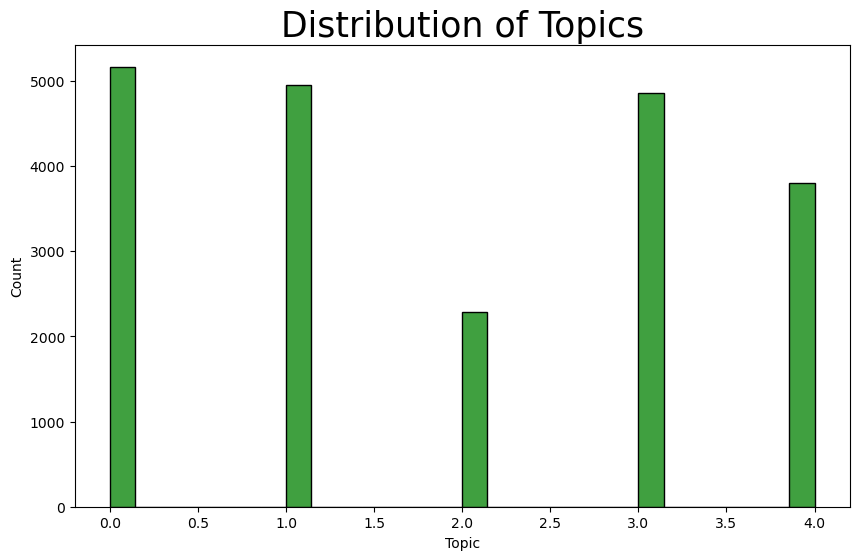

In [93]:
# Plotting a histogram of topics
plt.figure(figsize=[10,6])
sns.histplot(data=training_data, x='Topic',color='Green', )
plt.title("Distribution of Topics", fontsize=25)
plt.show()

### Apply the supervised models on the training data created.

In [94]:
count_vector=CountVectorizer()

#Write your code here to transform the word vector to tf-idf
X_train_count=count_vector.fit_transform(training_data['complaint_what_happened'])

import pickle

pickle.dump(count_vector.vocabulary_, open("count_vector.pkl","wb"))

In [95]:
tfidf_transform= TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_count)

In [96]:
# Save TF-IDF on disk for later usage
pickle.dump(tfidf_transform, open("tfidf.pkl","wb"))

In [97]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (15804, 27984)
y_train Shape: (15804,)
X_test Shape: (5268, 27984)
y_test Shape: (5268,)


In [106]:
#Evaluation MEtrics
# Create a function to evaluate models
def model_eval(y_test, y_pred, model_name):
    
    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
    # plot confusion matrix of the classifier
    plt.figure(figsize=(10,7))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Greens", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()
    
    return

In [ ]:
#Model:1 - Logistic Regression

In [100]:
# Import required library
from sklearn.linear_model import LogisticRegression

In [101]:
# Run the Logistic Regression model with default parameters
model_name = 'LOGISTIC REGRESSION'
lr = LogisticRegression() 
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [102]:
# Hyperparameter tuning for best result
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=lr, 
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/nishitgoyal/python/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nishitgoyal/python/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nishitgoyal/python/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nishitgoyal/python/anaconda3/lib/python3.11/site-packages

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [103]:
# Creating model with best hyperparameter
lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga')

lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)


In [104]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr


0.9429908817667709

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.94      0.96      0.95      1305
Credit card or prepaid card       0.95      0.95      0.95      1265
                     Others       0.94      0.95      0.94       563
    Theft/Dispute Reporting       0.94      0.91      0.93      1222
              Mortgage/Loan       0.94      0.95      0.94       913

                   accuracy                           0.94      5268
                  macro avg       0.94      0.94      0.94      5268
               weighted avg       0.94      0.94      0.94      5268



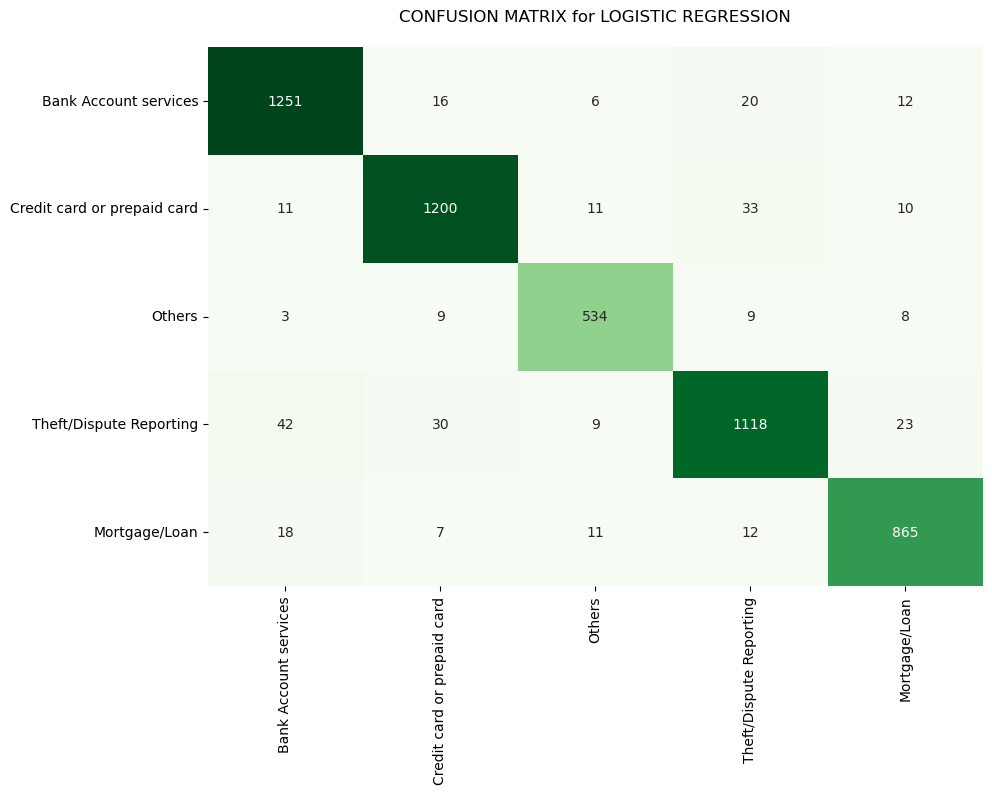

In [107]:
# Evaluate the tuned Logistic Regression classifier
model_eval(y_test, y_pred_lr_tuned, model_name)

In [108]:
#Model 2 : Niave Bayes

In [109]:
from sklearn.naive_bayes import MultinomialNB
model_name = 'NAIVE BAYES'
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [110]:
param_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=nb, 
                       param_grid=param_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_prior': False}


In [111]:
# Creating model with best hyperparameter
model_name = 'NAIVE BAYES'
nb_tuned = MultinomialNB(alpha=0.1,fit_prior=False)
nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = nb_tuned.predict(X_test)

In [112]:
# Calculate F1 Score of model using weighted average method
f1_nb = f1_score(y_test, y_pred_nb_tuned, average="weighted")
f1_nb

0.7792158040677712

CLASSIFICATION REPORT for NAIVE BAYES

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.83      0.80      1305
Credit card or prepaid card       0.80      0.75      0.78      1265
                     Others       0.66      0.63      0.65       563
    Theft/Dispute Reporting       0.77      0.77      0.77      1222
              Mortgage/Loan       0.83      0.85      0.84       913

                   accuracy                           0.78      5268
                  macro avg       0.77      0.77      0.77      5268
               weighted avg       0.78      0.78      0.78      5268



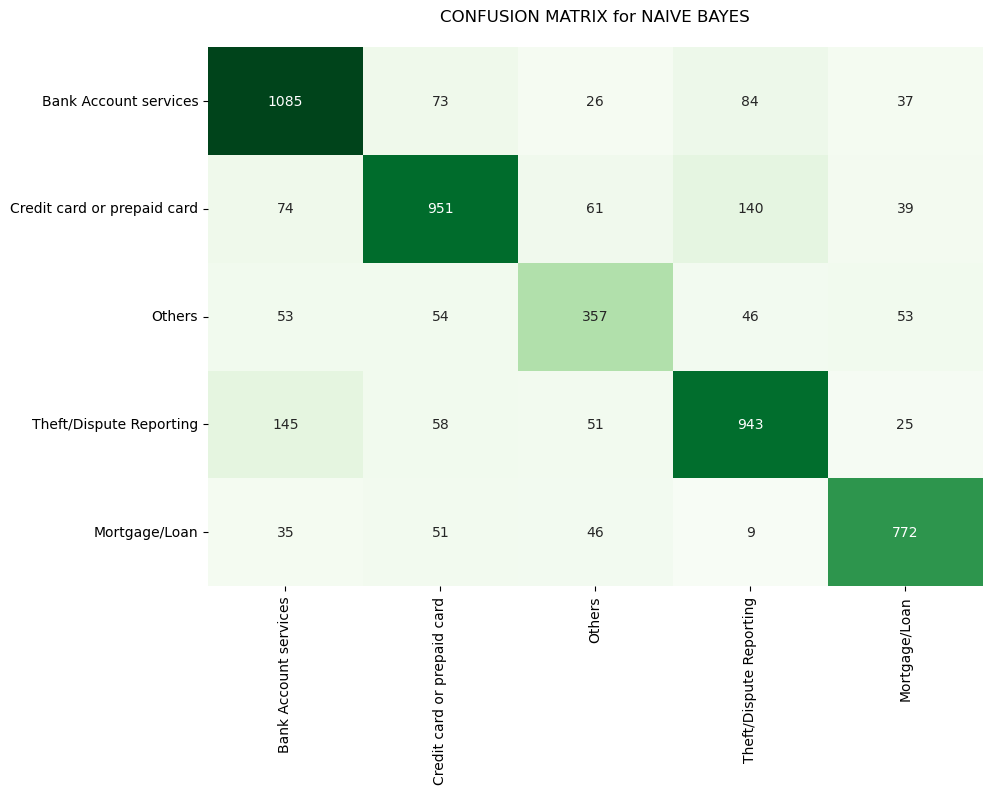

In [113]:
model_eval(y_test, y_pred_nb_tuned, model_name)


In [114]:
f1_summary = pd.DataFrame([{'Model': 'Naive Bayes','F1 Score': round(f1_nb, 2)}])
f1_summary

,Model,F1 Score
0,Naive Bayes,0.78


In [116]:
#Model 3:Decision Tree
# Import required library
from sklearn.tree import DecisionTreeClassifier

In [117]:
# Run Decision Tree with default hyperparameters
model_name = 'DECISION TREE'
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt =dt.predict(X_test)

In [118]:
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],
    
}

grid_dt = GridSearchCV(estimator=dt, 
                       param_grid=param_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 15}


In [119]:
dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=25, 
                                      min_samples_leaf=15, 
                                      )
dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)

In [120]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt

0.7872261270800831

In [ ]:
# Evaluate the tuned Decision Tree classifier
model_eval(y_test, y_pred_dt_tuned, model_name)

### Logistic Regression has best f1 score

In [121]:
pickle.dump(lr_tuned, open("logreg_model.pkl", "wb"))


### Predicting topics via Logistic Regression on custom text


In [122]:
def topic_predicter(text):
    
    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    load_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    load_tfidf = pickle.load(open("tfidf.pkl","rb"))
    load_model = pickle.load(open("logreg_model.pkl","rb"))

    X_new_count = load_vec.transform(text)
    X_new_tfidf = load_tfidf.transform(X_new_count)
    prediction = load_model.predict(X_new_tfidf)

    return target_names[prediction[0]]

In [134]:
# Create a dataframe of some sample customer complaints
df_custom = pd.DataFrame({'complaints': ["I can not get services of my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was too high.Need Help",
                                  "I want to open a  account at SBI",

                                  "How can I know my CIBIL score?",
                                  "Where are the bank branches in the city of Dehradun?"]})
df_custom

,complaints
0,"I can not get services of my mortgage, who owns it and who has original loan docs"
1,The bill amount of my credit card was too high.Need Help
2,I want to open a account at SBI
3,How can I know my CIBIL score?
4,Where are the bank branches in the city of Dehradun?


In [135]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_custom['predicted topic'] = df_custom['complaints'].apply(lambda x: topic_predicter([x]))
df_custom

,complaints,predicted topic
0,"I can not get services of my mortgage, who owns it and who has original loan docs",Mortgage/Loan
1,The bill amount of my credit card was too high.Need Help,Credit card or prepaid card
2,I want to open a account at SBI,Bank Account services
3,How can I know my CIBIL score?,Credit card or prepaid card
4,Where are the bank branches in the city of Dehradun?,Bank Account services
